In [1]:
%matplotlib inline

In [2]:
import ast
from calendar import month_name, day_name
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Recipe Recommendation System

## part 2 - Datasets and EDA

Dataset description:

Dataset constucted by collecting data from Allrecipes.com. The website is chosen since it is one of the largest food-oriented social networks with 1.5 billion visits per year. Includes 52,821 recipes from 27 categories posted between 2000 and 2018. For each recipe its ingredients, image and the corresponding ratings from users are crawled. To ensure the quality of the data, we filter recipes that do not have images and that contain repeated ingredients and zero reviews. Then we obtain raw_data, including 1,160,267 users, 49,698 recipes with 38,131 ingredients and 3,794,003 interactions.

https://www.kaggle.com/datasets/elisaxxygao/foodrecsysv1

### 1.0 Recipes

Let's take a look at the first few rows of our recipe dataset:

In [3]:
recipes = pd.read_csv("data/foodRecSys-V1_kaggle/raw-data_recipe.csv", nrows = 5)
recipes

,recipe_id,recipe_name,aver_rate,image_url,review_nums,ingredients,cooking_directions,nutritions,reviews
0,222388,Homemade Bacon,5.000000,https://images.media-allrecipes.com/userphotos...,3,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...,"{u'niacin': {u'hasCompleteData': False, u'name...","{8542392: {'rating': 5, 'followersCount': 11, ..."
1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,https://images.media-allrecipes.com/userphotos...,29,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...,"{u'niacin': {u'hasCompleteData': False, u'name...","{3574785: {'rating': 5, 'followersCount': 0, '..."
2,218939,Foolproof Rosemary Chicken Wings,4.571429,https://images.media-allrecipes.com/userphotos...,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady...","{u'niacin': {u'hasCompleteData': True, u'name'...","{13774946: {'rating': 5, 'followersCount': 0, ..."
3,87211,Chicken Pesto Paninis,4.625000,https://images.media-allrecipes.com/userphotos...,163,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{1563136: {'rating': 5, 'followersCount': 0, '..."
4,245714,Potato Bacon Pizza,4.500000,https://images.media-allrecipes.com/userphotos...,2,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...,"{u'niacin': {u'hasCompleteData': True, u'name'...","{2945555: {'rating': 5, 'followersCount': 6690..."


In [4]:
recipes.columns

Index(['recipe_id', 'recipe_name', 'aver_rate', 'image_url', 'review_nums',
       'ingredients', 'cooking_directions', 'nutritions', 'reviews'],
      dtype='object')

The recipe dataset has 9 features - integer id, name, average rating, image url, number of reviews, ingredients, cooking directions, nutrition and reviews.

In our study we are not interested in nutrition, the images are no longer available at the specified url, images are provided ad .jpeg files as part of the dataset. Reviews column contains dictionary with timestamp, rating, review text and user details for each review associated with the given recipe. The contents of "raw-data_interaction.csv" is the exploded version of this data - one row per review, without the text of the review and user details. We will explore this dataset later in this notebook. There is no valuable information in user details - we do not see a reason to recommend different content based on the engagement of the user with the platform (followersCount, followingCount, madeRecipesCount, favoritesCount). The text of the review could be useful with both it's sentiment and semantics - the comments frequently contain suggestions for ingredient substitution, alternative preparation methods ect. These could be used for the recipe representation, but we decided not to use it - our model turned out too big and slow even with the basic features only. 
These are the reasons to discard `image_url`, `nutritions` and `reviews`.

In [5]:
ast.literal_eval(recipes.reviews[0])

{8542392: {'rating': 5,
  'followersCount': 11,
  'madeRecipesCount': 18,
  'favoritesCount': 200,
  'dateLastModified': '2017-04-22T12:46:43.663',
  'text': "Best breakfast ever! I ran out of paprika while seasoning, so I used garlic piercer on the other half of the batch. Very good! Can't wait to make it again... and figure out how to use the drippings!",
  'followingCount': 0},
 11174581: {'rating': 5,
  'followersCount': 8,
  'madeRecipesCount': 55,
  'favoritesCount': 101,
  'dateLastModified': '2013-06-20T15:50:25.96',
  'text': "Awesome!\nIt's amazing.",
  'followingCount': 0},
 8262477: {'rating': 5,
  'followersCount': 0,
  'madeRecipesCount': 1,
  'favoritesCount': 52,
  'dateLastModified': '2015-02-14T07:27:51.307',
  'text': 'The flavors came together well and it really was simple to prepare. My husband and I both enjoyed it!',
  'followingCount': 0}}

In [6]:
cols_to_keep = [
    "recipe_id",
    "recipe_name", 
    "aver_rate", 
    "review_nums", 
    "ingredients", 
    "cooking_directions", 
    ]

We read the dataset keeping only the features of interest:

In [7]:
recipes = pd.read_csv("data/foodRecSys-V1_kaggle/raw-data_recipe.csv", usecols = cols_to_keep)
recipes

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,cooking_directions
0,222388,Homemade Bacon,5.000000,3,pork belly^smoked paprika^kosher salt^ground b...,{'directions': u'Prep\n5 m\nCook\n2 h 45 m\nRe...
1,240488,"Pork Loin, Apples, and Sauerkraut",4.764706,29,sauerkraut drained^Granny Smith apples sliced^...,{'directions': u'Prep\n15 m\nCook\n2 h 30 m\nR...
2,218939,Foolproof Rosemary Chicken Wings,4.571429,12,chicken wings^sprigs rosemary^head garlic^oliv...,"{'directions': u""Prep\n20 m\nCook\n40 m\nReady..."
3,87211,Chicken Pesto Paninis,4.625000,163,focaccia bread quartered^prepared basil pesto^...,{'directions': u'Prep\n15 m\nCook\n5 m\nReady ...
4,245714,Potato Bacon Pizza,4.500000,2,red potatoes^strips bacon^Sauce:^heavy whippin...,{'directions': u'Prep\n20 m\nCook\n45 m\nReady...
...,...,...,...,...,...,...
49693,222886,Grateful Dead Cocktail,3.500000,4,fluid ounce tequila^fluid ounce vodka^fluid ou...,{'directions': u'Prep\n5 m\nReady In\n5 m\nCom...
49694,25650,Cheese Filling For Pastries,4.333333,3,raisins^brandy^cream cheese^white sugar^all-pu...,{'directions': u'Prep\n15 m\nReady In\n15 m\nS...
49695,23544,Peach Smoothie,3.615385,21,sliced peaches drained^scoops vanilla ice crea...,{'directions': u'Prep\n1 m\nReady In\n1 m\nIn ...
49696,170710,Double Dare Peaches,4.714286,19,butter^habanero peppers^fresh peaches^brown su...,{'directions': u'Prep\n20 m\nCook\n10 m\nReady...


In [8]:
recipes.dtypes

recipe_id               int64
recipe_name            object
aver_rate             float64
review_nums             int64
ingredients            object
cooking_directions     object
dtype: object

Let's explore numerical values:

In [9]:
recipes.describe().T

,count,mean,std,min,25%,50%,75%,max
recipe_id,49698.0,131092.695119,98230.166389,6663.0,22244.250000,142057.500000,231644.750000,262956.0
aver_rate,49698.0,4.311699,0.485282,0.0,4.081311,4.411765,4.622239,5.0
review_nums,49698.0,76.342408,282.160920,1.0,6.000000,17.000000,54.000000,11191.0


The mean and standard deviation of recipe id have no real meaning, but from the min and max we can see that there are more ids than recipes, which is consistent with the dataset description - only recipes with valid interactions are included, leading to many vacant ids.

We make sure there are no duplicate rows and ids:

In [10]:
assert(recipes.duplicated().sum() == 0)
assert(recipes.duplicated(subset="recipe_id").sum() == 0)

And check for duplicate recipe names:

In [11]:
recipes.duplicated(subset="recipe_name", keep = False).sum() # keep = False for count all duplicates

1186

As expected, names are not unique. Let's investigate weather these are real duplicates or different recipes with the same name:

In [12]:
duplicated_recipes = recipes.duplicated(subset=["recipe_name", "ingredients", "cooking_directions"], keep = False)

In [13]:
duplicated_recipes.sum()

44

In [14]:
recipes[duplicated_recipes].recipe_name.value_counts()

recipe_name
Turkey Tenderloins                                     2
Thanksgiving Meatloaf                                  2
Dressing Patties                                       2
Sweet Potato Casserole V                               2
Orange and Onion Salad                                 2
Red Cabbage With Apricots And Balsamic Vinegar         2
Pumpkin Biscuits                                       2
Green Beans With Walnuts                               2
Cranberry Chutney I                                    2
Cranberry Sauce with Raspberry Vinegar                 2
Nutty Wild Rice Salad with Kiwifruit and Red Grapes    2
Michelle's Famous Washed Cranberry Sauce               2
Three Bean Salad                                       2
Hawaiian Fruit Crumble                                 2
Joey's Bread Pudding                                   2
Icelandic Christmas Cake                               2
Cherry Salad                                           2
Pecan Pie Bars II  

Let's pick one as example:

In [15]:
recipes[duplicated_recipes & (recipes.recipe_name == "German Christmas Gingerbread")]

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,cooking_directions
18821,9290,German Christmas Gingerbread,4.450000,15,butter^packed brown sugar^eggs^honey^orange li...,"{'directions': u'Whisk together the flours, ba..."
18980,7643,German Christmas Gingerbread,4.590909,16,butter^packed brown sugar^eggs^honey^orange li...,"{'directions': u'Whisk together the flours, ba..."


In [16]:
print(ast.literal_eval(recipes.iloc[18821].cooking_directions)["directions"])

Whisk together the flours, baking powder, and spices.
In a large bowl, cream the butter or margarine with the brown sugar. Beat in the eggs, then the honey, orange liqueur, sour cream, and orange juice. Beat the flour mixture into the creamed mixture, and then stir in the raisins and almonds. Turn batter into a greased and floured tube pan.
Bake cake at 350 degrees F (175 degrees C) for 80 minutes, or until it tests done with toothpick. Transfer to a rack to cool.


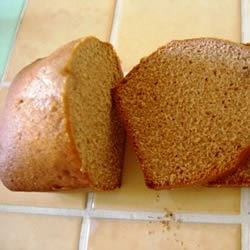 
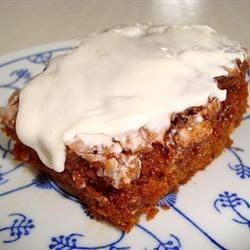

As far as we could see these are all duplicate recipes with different images. Having the same recipe twice is probably not very beneficial to our model, but since there are only 22 pairs out of almost 50 000 recipes, we decide they are too few to worry about and leave them be. 

`aver_rate`

The average rating is quite high, let's take a closer look at it's distribution:

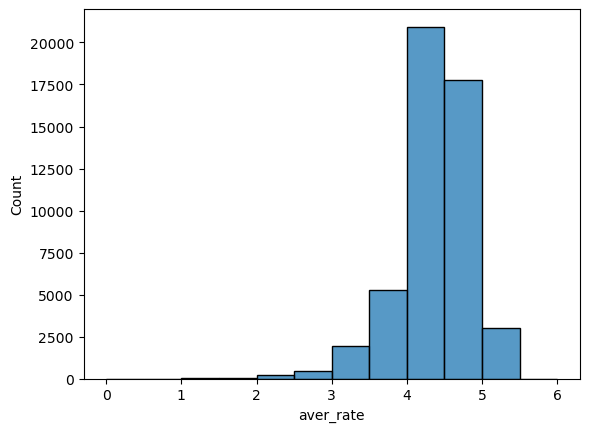

In [17]:
sns.histplot(recipes.aver_rate, binwidth = 0.5, binrange = [0, 6])
plt.show()

This distribution is probably distorted by the biased sampling - only ratings from reviews that are actual text are included, many more ratings without review are not accounted for. This makes comparing recipes' average rating meaningless.

`review_nums`

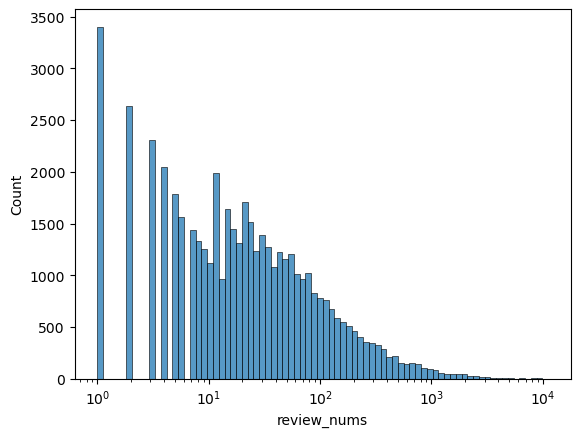

In [18]:
sns.histplot(recipes.review_nums, log_scale = True)
plt.show()

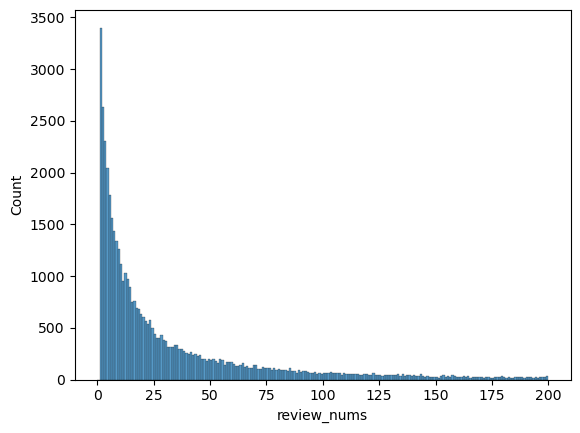

In [19]:
sns.histplot(recipes.review_nums, binwidth = 1, binrange = [0, 200])
plt.show()

As expected - huge number of recipes with single review (recipes with no reviews are not included in the dataset) and small number of recipes with many reviews. We do not want to filter our data based on cutoff number of reviews, since it will lead to discarding new recipes and keep older ones, which is highly undesirable.

Let's see the most popular ones:

In [20]:
recipes.nlargest(5, "review_nums")

,recipe_id,recipe_name,aver_rate,review_nums,ingredients,cooking_directions
7567,23600,World's Best Lasagna,4.787341,11191,sweet Italian sausage^lean ground beef^minced ...,{'directions': u'Prep\n30 m\nCook\n2 h 30 m\nR...
31498,20144,Banana Banana Bread,4.572033,10043,all-purpose flour^baking soda^salt^butter^brow...,{'directions': u'Prep\n15 m\nCook\n1 h 5 m\nRe...
30839,162760,Fluffy Pancakes,4.820761,9951,milk^white vinegar^all-purpose flour^white sug...,{'directions': u'Prep\n10 m\nCook\n10 m\nReady...
1062,56927,Delicious Ham and Potato Soup,4.837559,9829,peeled and diced potatoes^diced celery^finely ...,{'directions': u'Prep\n20 m\nCook\n25 m\nReady...
31571,17652,Banana Crumb Muffins,4.804039,9778,all-purpose flour^baking soda^baking powder^sa...,{'directions': u'Prep\n15 m\nCook\n20 m\nReady...


Meh, Lasagna is the winner with 11 000 reviews. Why is a mediocre dish like this the most popular (or why would you put vinegar in your pancakes as in number 3) is beyond my comprehension, but people have spoken.

It will be a good idea to save a list with the most popular to compare our model against a model that suggests the top 100 every time, but we will do that after deciding which recipes to keep in our final candidate set.

`recipe_name`

Let's see the length of the recipe names - number of characters and number of words:

In [61]:
char_count = recipes.recipe_name.apply(lambda x: len(x))

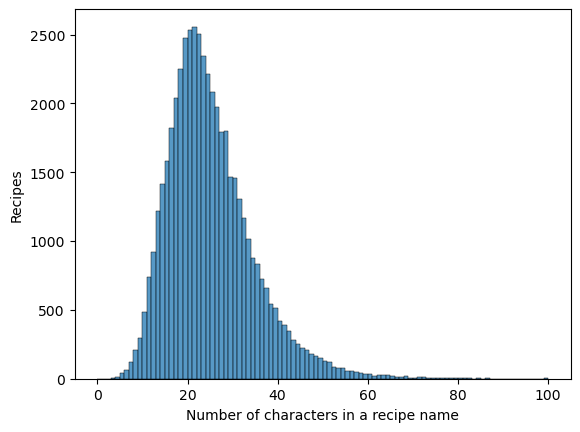

In [63]:
sns.histplot(char_count, binrange = [0, 100], binwidth = 1)

plt.xlabel("Number of characters in a recipe name")
plt.ylabel("Recipes")

plt.show()

In [64]:
word_count = recipes.recipe_name.str.split().apply(lambda x: len(x))

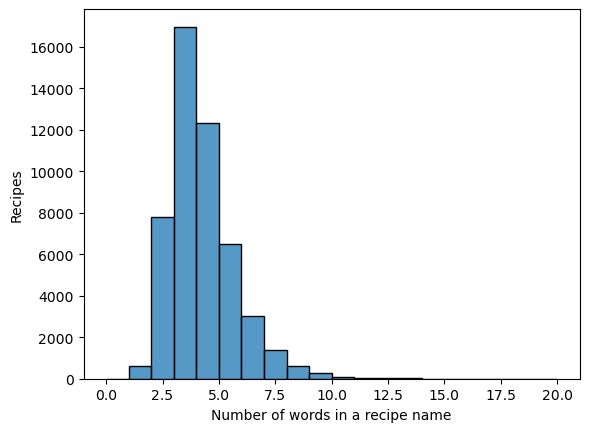

In [68]:
sns.histplot(word_count, binrange = [0, 20], binwidth = 1)

plt.xlabel("Number of words in a recipe name")
plt.ylabel("Recipes")

plt.show()

`ingredients`

In [21]:
recipes.ingredients = recipes.ingredients.str.split("^")

In [22]:
recipes.ingredients[0]

['pork belly', 'smoked paprika', 'kosher salt', 'ground black pepper']

In [23]:
type(recipes.ingredients[0])

list

Let's count the ingredients one by one and see which are the most common.

In [24]:
ingredients_flat = [ingredient for recipe in recipes.ingredients for ingredient in recipe]

In [25]:
ingredients_counter = Counter(ingredients_flat)

In [26]:
len(ingredients_counter)

38131

In [27]:
ingredients_counter.most_common(20)

[('salt', 15070),
 ('butter', 13263),
 ('white sugar', 13032),
 ('all-purpose flour', 10257),
 ('garlic', 8113),
 ('water', 7626),
 ('olive oil', 7531),
 ('vanilla extract', 6507),
 ('milk', 6258),
 ('eggs', 5856),
 ('vegetable oil', 5105),
 ('ground black pepper', 4976),
 ('ground cinnamon', 4462),
 ('baking powder', 3905),
 ('onion', 3844),
 ('baking soda', 3609),
 ('egg', 3594),
 ('salt and pepper to taste', 3272),
 ('brown sugar', 2963),
 ('salt and ground black pepper to taste', 2779)]

Even in the top 20 we have duplicates - 'salt and pepper to taste' and 'salt and ground black pepper to taste', not to mention that 'salt' and 'ground black pepper' are there separately too. 

And the least common:

In [28]:
ingredients_counter.most_common()[-20:]

[('jalapeno-stuffed green olives', 1),
 ('fluid ounce) jiggers premium tequila', 1),
 ('fluid ounce) jigger orange liqueur', 1),
 ('fluid ounce) jigger sweetened lime juice', 1),
 ('fluid ounces beer (such as Miller® High Life®)', 1),
 ('fluid ounces cola-flavored carbonated beverage (such as Coca-Cola®)', 1),
 ('fresh red currants', 1),
 ('fluid ounces liquid fruit pectin', 1),
 ('Almond Breeze Coconutmilk Almondmilk Original Unsweetened', 1),
 ('Meyer lemon juiced and peeled', 1),
 ('fluid ounces spiced rum (such as Kraken®)', 1),
 ('fluid ounce freshly squeezed orange juice', 1),
 ('fluid ounce white rum (such as Captain Morgan™)', 1),
 ("fluid ounce dark rum (such as Myers's®)", 1),
 ('fluid ounce hibiscus syrup', 1),
 ('fluid ounce almond orgeat syrup (such as Torani®)', 1),
 ('black beans drained and liquid reserved', 1),
 ('fluid ounces reduced calorie cranberry juice cocktail', 1),
 ('fluid ounces reduced calorie lemonade', 1),
 ('crushed jalapeno and habanero peanut brittle (s

At the tail of most common are typos, measuring units included in the ingredient name, brands and preparation methods ("squeezed", "juiced and peeled") which are all a problem for accurate counting. That means we cannot vectorize ingredients as categories and need some text processing.


In [29]:
top_20 = ingredients_counter.most_common(20)
most_common_keys = list(reversed([x[0] for x in top_20]))
most_common_counts = list(reversed([x[1] for x in top_20]))

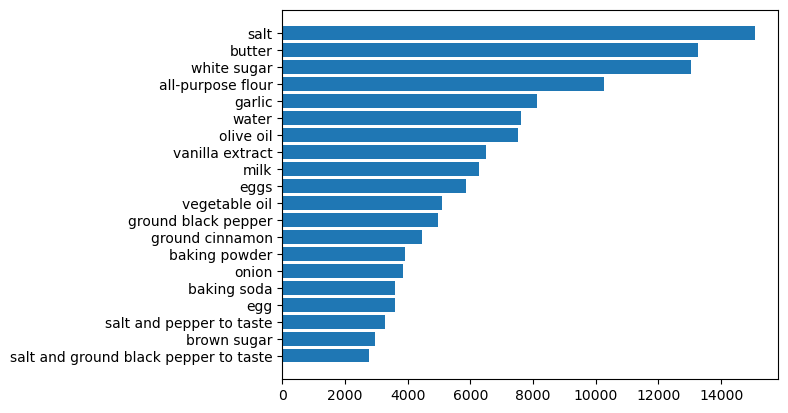

In [30]:
plt.barh(most_common_keys, most_common_counts)
plt.show()

In [56]:
ingredient_count = recipes.ingredients.apply(lambda x: len(x))

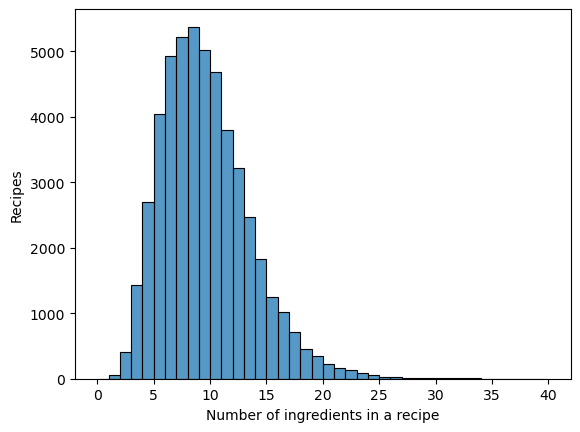

In [60]:
sns.histplot(ingredient_count, binrange = [0, 40], binwidth = 1)

plt.xlabel("Number of ingredients in a recipe")
plt.ylabel("Recipes")

plt.show()

`cooking_directions`

In [31]:
recipes.cooking_directions = recipes.cooking_directions.apply(ast.literal_eval)

In [32]:
# Make sure there is only "directions" info
assert(recipes.cooking_directions.apply(lambda x: len(x.keys()) == 1).all())
assert(recipes.cooking_directions.apply(lambda x: list(x.keys())[0] == "directions").all())

In [33]:
recipes.cooking_directions[0]["directions"]

'Prep\n5 m\nCook\n2 h 45 m\nReady In\n11 h 50 m\nPreheat oven to 200 degrees F (95 degrees C).\nSeason pork belly with paprika, salt, and pepper. Tightly wrap pork twice in heavy-duty aluminum foil. Place on a baking sheet and bake in the preheated oven for 2 1/2 hours. Turn off the oven; let pork rest in the oven for 1 hour. Remove meat from oven, leaving it wrapped in aluminum foil, and refrigerate at least 8 hours or overnight.\nRemove pork from foil and slice across the grain in 1/4-inch thick slices. Working in batches, cook pork in a non-stick skillet over medium heat until golden and crisped, 6 to 8 minutes per slice.'

In [34]:
# reduce to string
recipes.cooking_directions = recipes.cooking_directions.apply(lambda x: list(x.values())[0])
assert all(isinstance(directions, str) for directions in recipes.cooking_directions)

In [35]:
print(recipes.cooking_directions[0])

Prep
5 m
Cook
2 h 45 m
Ready In
11 h 50 m
Preheat oven to 200 degrees F (95 degrees C).
Season pork belly with paprika, salt, and pepper. Tightly wrap pork twice in heavy-duty aluminum foil. Place on a baking sheet and bake in the preheated oven for 2 1/2 hours. Turn off the oven; let pork rest in the oven for 1 hour. Remove meat from oven, leaving it wrapped in aluminum foil, and refrigerate at least 8 hours or overnight.
Remove pork from foil and slice across the grain in 1/4-inch thick slices. Working in batches, cook pork in a non-stick skillet over medium heat until golden and crisped, 6 to 8 minutes per slice.


### 2.0 Ratings

This is the interactions dataset we mentioned earlier. Let's read it:

In [37]:
interactions = pd.read_csv("data/foodRecSys-V1_kaggle/raw-data_interaction.csv")
interactions

,user_id,recipe_id,rating,dateLastModified
0,8542392,222388,5,2017-04-22T12:46:43.663\n
1,11174581,222388,5,2013-06-20T15:50:25.96\n
2,8262477,222388,5,2015-02-14T07:27:51.307\n
3,3574785,240488,5,2017-10-07T18:20:08.973\n
4,12145410,240488,2,2018-01-06T00:06:09.563\n
...,...,...,...,...
3793998,12318233,170710,5,2013-11-03T11:09:47.763\n
3793999,51226,170710,5,2009-07-18T19:33:36.317\n
3794000,1476783,170710,5,2009-07-27T10:21:45.823\n
3794001,1245064,79774,4,2006-01-21T20:57:09.327\n


In [38]:
interactions.dtypes

user_id              int64
recipe_id            int64
rating               int64
dateLastModified    object
dtype: object

Parse the dates:

In [39]:
interactions.dateLastModified = pd.to_datetime(interactions.dateLastModified, format = "ISO8601")

And explore the data:

In [40]:
interactions.describe().T

,count,mean,min,25%,50%,75%,max,std
user_id,3794003.0,4860242.781291,16.0,1404674.0,2954489.0,6384689.0,23463743.0,5010314.80268
recipe_id,3794003.0,61121.799155,6663.0,14235.0,23390.0,78649.0,262956.0,71787.206572
rating,3794003.0,4.513192,1.0,4.0,5.0,5.0,5.0,0.875418
dateLastModified,3794003,2010-10-22 14:10:57.267878656,2000-02-07 21:06:30.137000,2008-02-25 06:23:30.880000,2010-10-25 12:15:48.150000128,2013-12-24 06:31:24.813499904,2018-03-16 07:19:52.260000,NaN


In [41]:
len(interactions.recipe_id.unique()) # == len(recipes)


49698

In [42]:
len(interactions.user_id.unique())

1160267

The mean and std of `user_id` and `recipe_id` don't realy have a meaning, but from the min and max we can see that there are vacant ids for both. 

Let's see the distribution of number of reviews per user:

In [43]:
user_num_reviews = interactions.user_id.value_counts() # number of reviews for each user

In [44]:
user_num_reviews.head()

user_id
2043209    4003
1153011    2496
2945555    2148
268713     2045
827351     1800
Name: count, dtype: int64

Text(0, 0.5, 'Users Count')

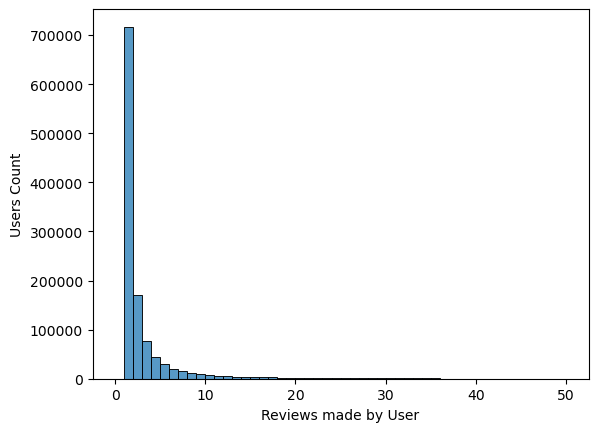

In [45]:
sns.histplot(user_num_reviews, binrange = [0, 50], binwidth = 1)

plt.xlabel("Reviews made by User")
plt.ylabel("Users Count")

Just like the reviews per recipe, the reviews per user have exponental distribution - huge number of users with single review, most users with few reviews and few users with huge number of reviews.

In [46]:
user_num_reviews_binned = pd.cut(user_num_reviews, bins=[0, 1, 2, 5, 10, 20, 50, 100, 1000, 2000, 5000]).value_counts()
user_num_reviews_binned

count
(0, 1]          717096
(1, 2]          171381
(2, 5]          151122
(5, 10]          62844
(10, 20]         33791
(20, 50]         18205
(50, 100]         4039
(100, 1000]       1764
(1000, 2000]        21
(2000, 5000]         4
Name: count, dtype: int64

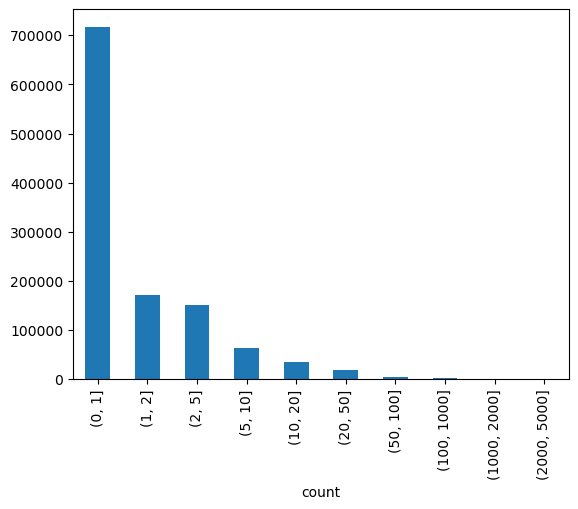

In [47]:
user_num_reviews_binned.plot.bar()
plt.show()

`rating`

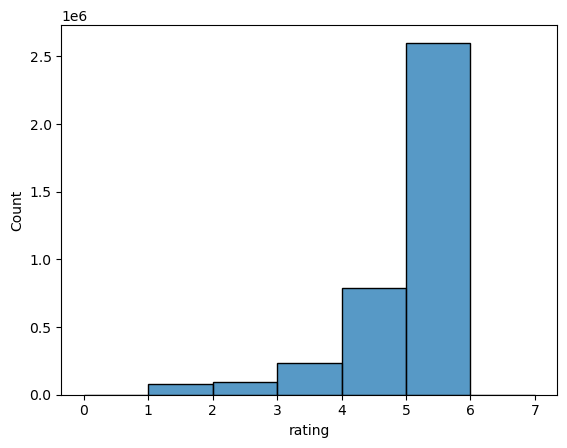

In [48]:
sns.histplot(interactions.rating, binwidth = 1, binrange = [0, 7])
plt.show()

The reviews are mostly positive, very low number of bad ratings.

`dateLastModified`

This is effectively a timestamp of the review, or the last time it has been modified. Note that it is NOT a recipe attribute - we have no data when the recipe was created or updated.

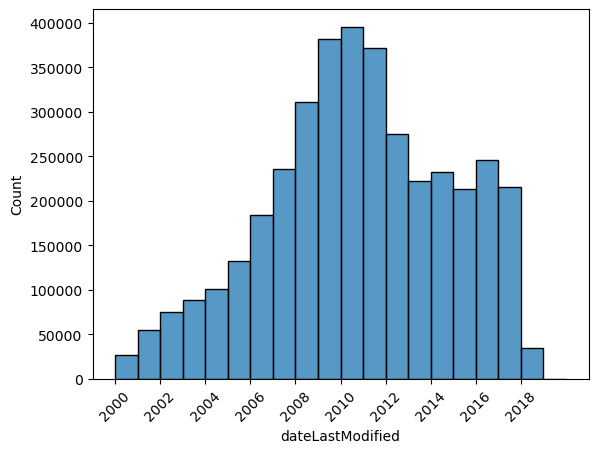

In [49]:
sns.histplot(interactions.dateLastModified.dt.year, binwidth = 1, binrange = [2000, 2020])
plt.xticks(range(2000, 2020, 2), rotation = 45)
plt.show()

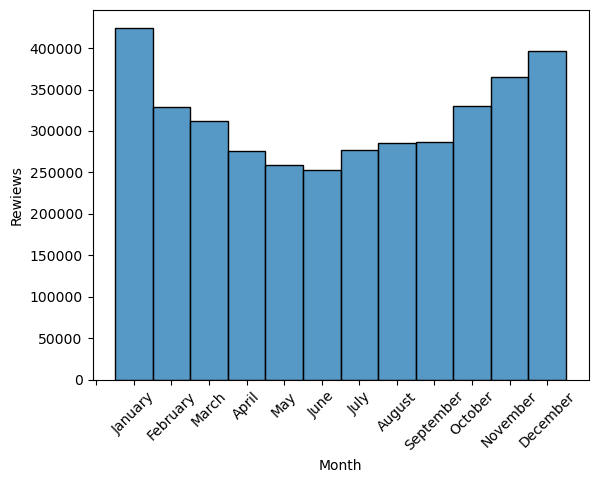

In [50]:
sns.histplot(interactions.dateLastModified.dt.month, binwidth = 1, binrange = [1, 13])

plt.xlabel("Month")
plt.ylabel("Rewiews")
plt.xticks(ticks=np.arange(0.5, 13.5), labels=list(month_name), rotation = 45)

plt.show()

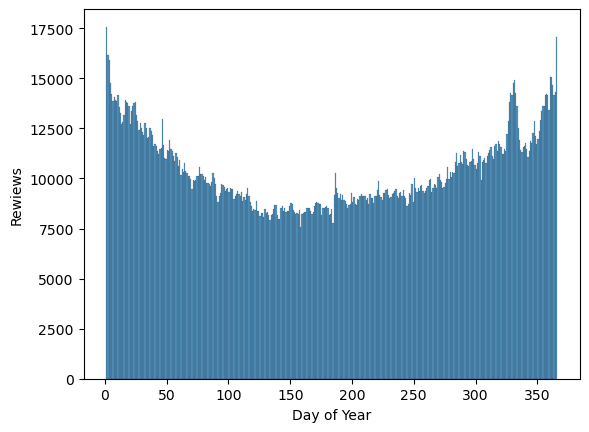

In [51]:
sns.histplot(interactions.dateLastModified.dt.day_of_year, binwidth = 1, binrange = [1, 366])

plt.xlabel("Day of Year")
plt.ylabel("Rewiews")

plt.show()

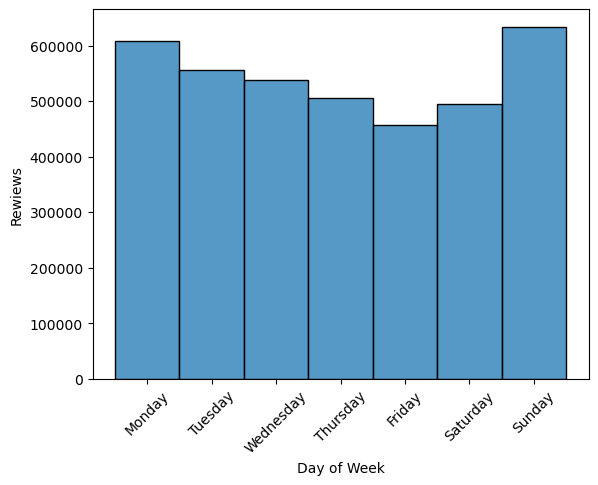

In [52]:
sns.histplot(interactions.dateLastModified.dt.day_of_week, binwidth = 1, binrange = [0, 7])

plt.xlabel("Day of Week")
plt.ylabel("Rewiews")

plt.xticks(ticks=np.arange(0.5, 7.5), labels=list(day_name), rotation = 45)

plt.show()

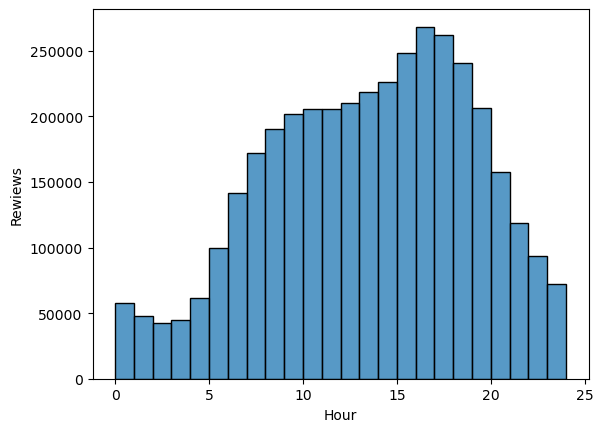

In [53]:

sns.histplot(interactions.dateLastModified.dt.hour, binwidth = 1, binrange = [0, 24])

plt.xlabel("Hour")
plt.ylabel("Rewiews")

plt.show()

There is clear seasonality in the data - yearly, weekly and daily patterns, so adding this feature to the model would be beneficial. Date could be used also as prompt for the recommendation - we need the pumpkin recipes for Halloween, and not so much for Christmas.